In [2]:
import glob
import os
import numpy as np
import pandas as pd
import scipy.signal
import skimage
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

plt.style.use('styleNB.mplstyle')
   
ip = 200.0/303.0

## Grab data

lets grab the files I'll be working with. In this experiment I look ~30 min videos (60 sec  intervals, 30 frames), 3 $\mu$m slides over 300 $\mu$m - using the water 20x objective. One channel is phase, while the other is the DNA (using Heocht stain at 1 $\mu$g/ml for 15 min in flask prior to cell collection).  I took data at 0V/cm, 3 V/cm, and 5 V/cm. Note that in this batch of knockdown lines (i.e. performed fall of 2023) I also performed a density gradient clean up for all preps (using Polymorpprep), so there may be something meaningful in the number of cells that lack motile activity.

In [2]:
filelist = glob.glob(f_dir + 'processed_tracking/2024*/202405*.csv')
print(filelist)

['../../data/processed_tracking/20240506_trackmate_kalman_heonsu/20240506_dHL60_TMEM154KO-clone1_-30GFP-galvanin-HA_3um_60sec_3Vcm_1_tracks.csv', '../../data/processed_tracking/20240506_trackmate_kalman_heonsu/20240506_dHL60_TMEM154KO-clone1_-30GFP-galvanin-HA_3um_60sec_5Vcm_1_tracks.csv', '../../data/processed_tracking/20240506_trackmate_kalman_heonsu/20240506_dHL60_TMEM154KO-clone1_-30GFP-galvanin-HA_3um_60sec_0Vcm_1_tracks.csv', '../../data/processed_tracking/20240506_trackmate_kalman_heonsu/20240506_dHL60_TMEM154KO-clone1_-30GFP-galvanin-HA_3um_60sec_1Vcm_1_tracks.csv', '../../data/processed_tracking/20240515_trackmate_kalman_heonsu/20240515_dHL60_TMEM154KO-clone1_+9GFP-galvanin-HA_3um_60sec_1Vcm_1_tracks.csv', '../../data/processed_tracking/20240515_trackmate_kalman_heonsu/20240515_dHL60_TMEM154KO-clone1_+9GFP-galvanin-HA_3um_60sec_0Vcm_1_tracks.csv', '../../data/processed_tracking/20240515_trackmate_kalman_heonsu/20240515_dHL60_TMEM154KO-clone1_+9GFP-galvanin-HA_3um_60sec_5Vcm_1_

In [3]:
df = pd.DataFrame()

for file in filelist:

    df_temp = pd.read_csv(file, skiprows=[0,2,3,4])
    df_temp = df_temp[['Track ID', 'Frame', 'X', 'Y', 'Z']]
    df_temp.columns = ['cell', 'frame', 'x', 'y', 'z']

    df_temp['celltype'] = ''.join(file.split('/')[-1].split('_3um_60sec')[0].split('_')[1:]) 
    df_temp['acqtime'] = '60sec'
    df_temp['E_V_cm'] = file.split('Vcm')[0].split('_')[-1]
    df_temp['date'] = file.split('/')[-1].split('_')[0]
    df_temp['material'] = 'collagen'
    df_temp['concentration'] = '0.75 mg/ml'
    df_temp['scope'] = 'Sydney'
    df_temp['magnification'] = '20xWater'
    df_temp['trial'] = file.split('cm_')[-1].split('_')[0]
    df_temp['media'] = 'L15 10%FBS'
    df_temp['analysis_date'] = '20240320'
    if 'tara' in file:
        df_temp['user'] = 'TE'
    elif 'heonsu' in file:
        df_temp['user'] = 'HK'
    else:
        df_temp['user'] = 'NB'
    

    df = pd.concat([df, df_temp], ignore_index = True)



In [4]:
df_groups = df.groupby(['celltype', 'E_V_cm', 'trial', 'date', 'user'])
for i, data in df_groups:
    print(i)

('dHL60TMEM154KO-clone1+9GFP-galvanin-HA', '0', '1', '20240515', 'HK')
('dHL60TMEM154KO-clone1+9GFP-galvanin-HA', '0', '1', '20240521', 'NB')
('dHL60TMEM154KO-clone1+9GFP-galvanin-HA', '1', '1', '20240515', 'HK')
('dHL60TMEM154KO-clone1+9GFP-galvanin-HA', '1', '1', '20240521', 'NB')
('dHL60TMEM154KO-clone1+9GFP-galvanin-HA', '3', '1', '20240515', 'HK')
('dHL60TMEM154KO-clone1+9GFP-galvanin-HA', '3', '1', '20240521', 'NB')
('dHL60TMEM154KO-clone1+9GFP-galvanin-HA', '5', '1', '20240515', 'HK')
('dHL60TMEM154KO-clone1-30GFP-galvanin-HA', '0', '1', '20240506', 'HK')
('dHL60TMEM154KO-clone1-30GFP-galvanin-HA', '0', '1', '20240507', 'HK')
('dHL60TMEM154KO-clone1-30GFP-galvanin-HA', '0', '1', '20240514', 'HK')
('dHL60TMEM154KO-clone1-30GFP-galvanin-HA', '0', '1', '20240521', 'NB')
('dHL60TMEM154KO-clone1-30GFP-galvanin-HA', '1', '1', '20240506', 'HK')
('dHL60TMEM154KO-clone1-30GFP-galvanin-HA', '1', '1', '20240507', 'HK')
('dHL60TMEM154KO-clone1-30GFP-galvanin-HA', '1', '1', '20240514', 'HK')

In [5]:
df = df[['cell', 'frame', 'x', 'y', 'z', 'celltype', 
      'E_V_cm', 'date', 'trial', 'user']]

In [6]:
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [7]:
# remove cells that were not detected in every frame (I don't think this is actually needed)
df_temp = pd.DataFrame()
for sg, d in df.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'cell']):
#     print(sg)
    if (len(d.frame.unique())-1) == (d.frame.max() - d.frame.min()):
        df_temp = df_temp.append(d, ignore_index = True)

/var/folders/hs/8f67z23n6g9g9g4y03yhrn_c0000gn/T/ipykernel_5290/4244195761.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(d, ignore_index = True)


In [8]:
df = df_temp.sort_values(['frame', 'cell'])

In [9]:
# check number of cells in data
for sg, d in df.groupby(['celltype', 'E_V_cm', 'date', 'trial']):
    print(sg)
    print(len(d.frame.unique()))
    
    count = 0
    for g, d_ in d.groupby(['cell']):
        count += 1
    print(count)

('dHL60TMEM154KO-clone1+9GFP-galvanin-HA', '0', '20240515', '1')
31
264
('dHL60TMEM154KO-clone1+9GFP-galvanin-HA', '0', '20240521', '1')
31
603
('dHL60TMEM154KO-clone1+9GFP-galvanin-HA', '1', '20240515', '1')
31
327
('dHL60TMEM154KO-clone1+9GFP-galvanin-HA', '1', '20240521', '1')
31
519
('dHL60TMEM154KO-clone1+9GFP-galvanin-HA', '3', '20240515', '1')
31
259
('dHL60TMEM154KO-clone1+9GFP-galvanin-HA', '3', '20240521', '1')
31
494
('dHL60TMEM154KO-clone1+9GFP-galvanin-HA', '5', '20240515', '1')
31
237
('dHL60TMEM154KO-clone1-30GFP-galvanin-HA', '0', '20240506', '1')
31
364
('dHL60TMEM154KO-clone1-30GFP-galvanin-HA', '0', '20240507', '1')
31
360
('dHL60TMEM154KO-clone1-30GFP-galvanin-HA', '0', '20240514', '1')
31
265
('dHL60TMEM154KO-clone1-30GFP-galvanin-HA', '0', '20240521', '1')
30
341
('dHL60TMEM154KO-clone1-30GFP-galvanin-HA', '1', '20240506', '1')
31
365
('dHL60TMEM154KO-clone1-30GFP-galvanin-HA', '1', '20240507', '1')
31
321
('dHL60TMEM154KO-clone1-30GFP-galvanin-HA', '1', '20240514

## Visualize all tracks

In [ ]:
# for sg, d in df.groupby(['celltype']):
#     print(sg)
    
#     count = 0
#     for g, d_ in d.groupby(['E_V_cm', 'date', 'trial']):
#         count += 1

#     f, ax = plt.subplots(count, 1, figsize=(6,count*6))    
#     ax = ax.ravel()


#     aq = 0
#     for g, d_ in d.groupby(['E_V_cm', 'date', 'trial']):
#         print(g)
            
#         ##################################
#         # plot tracks
#         ##################################
#         num_cells = len(d_.cell.unique())
#         for i in np.arange(0,num_cells):
#             data_ = d_[d_.cell==i]

#             data_ = data_.replace([np.inf, -np.inf], np.nan)
#             d_x = data_.x[~np.isnan(data_.x)] 
#             d_y = data_.y[~np.isnan(data_.y)] 
#             d_z = data_.z[~np.isnan(data_.z)] 
           
#             if len(d_x)==0:
#                 continue

#             x = data_.x.values 
#             y = data_.y.values 
#             z = data_.z.values 


#             ax[aq].plot(data_.x.values - 1024.0*ip, 
#                            1024.0*ip - data_.y.values)
#             ax[aq].set_xlabel('x position ($\mu$m)')
#             ax[aq].set_ylabel('y position ($\mu$m)')
#             ax[aq].set_xlim(-676,0)
#             ax[aq].set_ylim(0,676)
#             ax[aq].set_title(sg + '_' + str(g[0]) + 'E_V_cm_' + str(g[1]) +
#                              '_trial_' + str(g[2]))# + ', ' + g[0] + '\n' + 'date: ' + str(g[2]) + ', trial: ' + str(g[3]))


            
#         aq += 1
        
#     plt.tight_layout()

## Drift correction and identify motile cells


In [10]:
df_filtered = pd.DataFrame()
df_ignore_nonmotile = pd.DataFrame()
df_ignore_other = pd.DataFrame()

for sg, d in df.groupby(['celltype']):
    print(sg)
    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
        print(g)
        tot_len = len(d_.frame.unique())

        
        ##################################
        # identify non-motile cells for drift correction
        ##################################
        nonmotile_cells = []
        if np.all([sg == 'dHL60TMEM154KO-clone1', g[0] == '5', g[1] == '20240229', g[-1] == 'HK']):
            print('yes')
            for x in [34, 22, 98, 159, 36, 62, 17, 110, 59, 94, 112, 129, 78, 123]:
                nonmotile_cells = np.append(nonmotile_cells, x)

        elif np.all([sg == 'dHL60TMEM154KO-clone1', g[0] == '1', g[1] == '20240320', g[-1] == 'TE']):
            print('yes')
            for x in [117, 142, 120, 72, 76, 46, 15, 41, 121, 16, 55, 129, 128, 141]:
                nonmotile_cells = np.append(nonmotile_cells, x) 
        else:
            
            for i in d_.cell.unique():
                data_ = d_[d_.cell==i]


                data_ = data_.replace([np.inf, -np.inf], np.nan)
                d_x = data_.x[~np.isnan(data_.x)] 
                d_y = data_.y[~np.isnan(data_.y)] 
                d_z = data_.z[~np.isnan(data_.z)] 

                if len(d_x) == tot_len:
                    if np.any([np.ptp(d_x)<=5.0, np.ptp(d_y)<=5.0]):
                        nonmotile_cells = np.append(nonmotile_cells, i)    

        s_x = [0]
        s_y = [0]
        s_z = [0]
        df_nonmotile = d_[d_.cell.isin(nonmotile_cells)]

        for t in np.arange(0,tot_len):
            if t == 0:
                continue
            shift_temp_x = []
            shift_temp_y = []
            shift_temp_z = []
            for cell, d_nm in df_nonmotile.groupby('cell'):
                shift_temp_x = np.append(shift_temp_x, d_nm[d_nm.frame==t].x.values - d_nm[d_nm.frame==t-1].x.values)
                shift_temp_y = np.append(shift_temp_y, d_nm[d_nm.frame==t].y.values - d_nm[d_nm.frame==t-1].y.values)
                shift_temp_z = np.append(shift_temp_z, d_nm[d_nm.frame==t].z.values - d_nm[d_nm.frame==t-1].z.values)
            
            s_x = np.append(s_x, np.mean(shift_temp_x))
            s_y = np.append(s_y, np.mean(shift_temp_y))
            s_z = np.append(s_z, np.mean(shift_temp_z))
        
        print(nonmotile_cells)
            
        ##################################
        # Apply drift correction, plot, and save motile cell track data
        ##################################

        for i in d_.cell.unique():
            data_ = d_[d_.cell==i]
            if len(data_.frame.unique()) != len(np.arange(data_.frame.min(), data_.frame.max()+1)):
                continue
                
            data_ = data_.replace([np.inf, -np.inf], np.nan)
            d_x = data_.x[~np.isnan(data_.x)] 
            d_y = data_.y[~np.isnan(data_.y)] 
            d_z = data_.z[~np.isnan(data_.z)] 
           
            if len(d_x)==0:
                continue

            if len(d_x) >=15:
                if len(df_nonmotile) == 0:
                    data_['x_shifted'] = data_['x']
                    data_['y_shifted'] = data_['y']
                    data_['z_shifted'] = data_['z']
                    d_s_x = data_.x_shifted
                    d_s_y = data_.y_shifted
                    d_s_z = data_.z_shifted
                else:
                    x = data_.x.values - np.cumsum(s_x[int(data_.frame.min()):int(data_.frame.max())+1])
                    y = data_.y.values - np.cumsum(s_y[int(data_.frame.min()):int(data_.frame.max())+1])
                    z = data_.z.values - np.cumsum(s_z[int(data_.frame.min()):int(data_.frame.max())+1])
                    data_['x_shifted'] = x
                    data_['y_shifted'] = y
                    data_['z_shifted'] = z
                    d_s_x = data_.x_shifted
                    d_s_y = data_.y_shifted
                    d_s_z = data_.z_shifted
   

                #########################
                # save to dataframe
                #########################            
                if i in nonmotile_cells:
                    df_ignore_nonmotile = pd.concat([df_ignore_nonmotile, data_], 
                                             ignore_index = True)
                    
                elif np.sqrt(np.ptp(d_s_x)**2 + np.ptp(d_s_y)**2 + np.ptp(d_s_z)**2) >=20:
                
#                 np.all([np.ptp(d_s_x)>=8, np.ptp(d_s_y)>=8, np.ptp(d_s_z)>=8]):                
                    df_filtered = pd.concat([df_filtered, data_], 
                                            ignore_index = True)
                    
                else:
                    df_ignore_other = pd.concat([df_ignore_other, data_], 
                                          ignore_index = True)
            
        aq += 1
        
#     plt.tight_layout()

dHL60TMEM154KO-clone1+9GFP-galvanin-HA
('0', '20240515', '1', 'HK')
[  7.   9.  15.  26.  54.  63.  68.  73.  81.  96. 101. 108. 112. 116.
 118. 119. 148. 156.]
('0', '20240521', '1', 'NB')
[ 25.  30.  90.  91.  95. 147. 181. 205.]
('1', '20240515', '1', 'HK')
[  2.  14.  53.  54.  61.  64.  66.  67.  76.  89.  95. 107. 113. 116.
 117. 123. 132. 152. 172. 176. 177. 178. 179. 182.]
('1', '20240521', '1', 'NB')
[  2.   3.  15.  23.  27.  30.  31.  36.  38.  56. 113. 122. 143. 158.
 162. 163. 192. 210.]
('3', '20240515', '1', 'HK')
[  9.  17.  18.  20.  23.  26.  35.  36.  44.  48.  49.  50.  52.  57.
  59.  67.  80.  86.  93.  98.  99. 100. 103. 106. 122. 125. 126. 128.
 135. 138. 139.]
('3', '20240521', '1', 'NB')
[  4.  22.  26.  28.  31.  34.  50.  67. 109. 110. 127. 131. 164. 170.
 185. 199.]
('5', '20240515', '1', 'HK')
[  2.   3.  16.  19.  23.  25.  37.  41.  44.  49.  50.  56.  66.  67.
  69.  73.  75.  83.  90.  92.  99. 102. 104. 106. 110. 113. 114. 115.
 117. 122. 129. 133. 13

/Users/nathanb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nathanb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nathanb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nathanb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nathanb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nathanb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: inva

[]
('5', '20240514', '1', 'HK')
[  1.   2.   4.   5.   7.   9.  13.  14.  15.  20.  21.  27.  30.  31.
  33.  34.  37.  39.  40.  41.  42.  49.  51.  53.  54.  61.  63.  72.
  74.  76.  78.  79.  88.  90.  92.  93.  96.  97. 100. 108. 109. 110.]


dHL60TMEM154KO-clone1+9GFP-galvanin-HA
dHL60TMEM154KO-clone1-30GFP-galvanin-HA


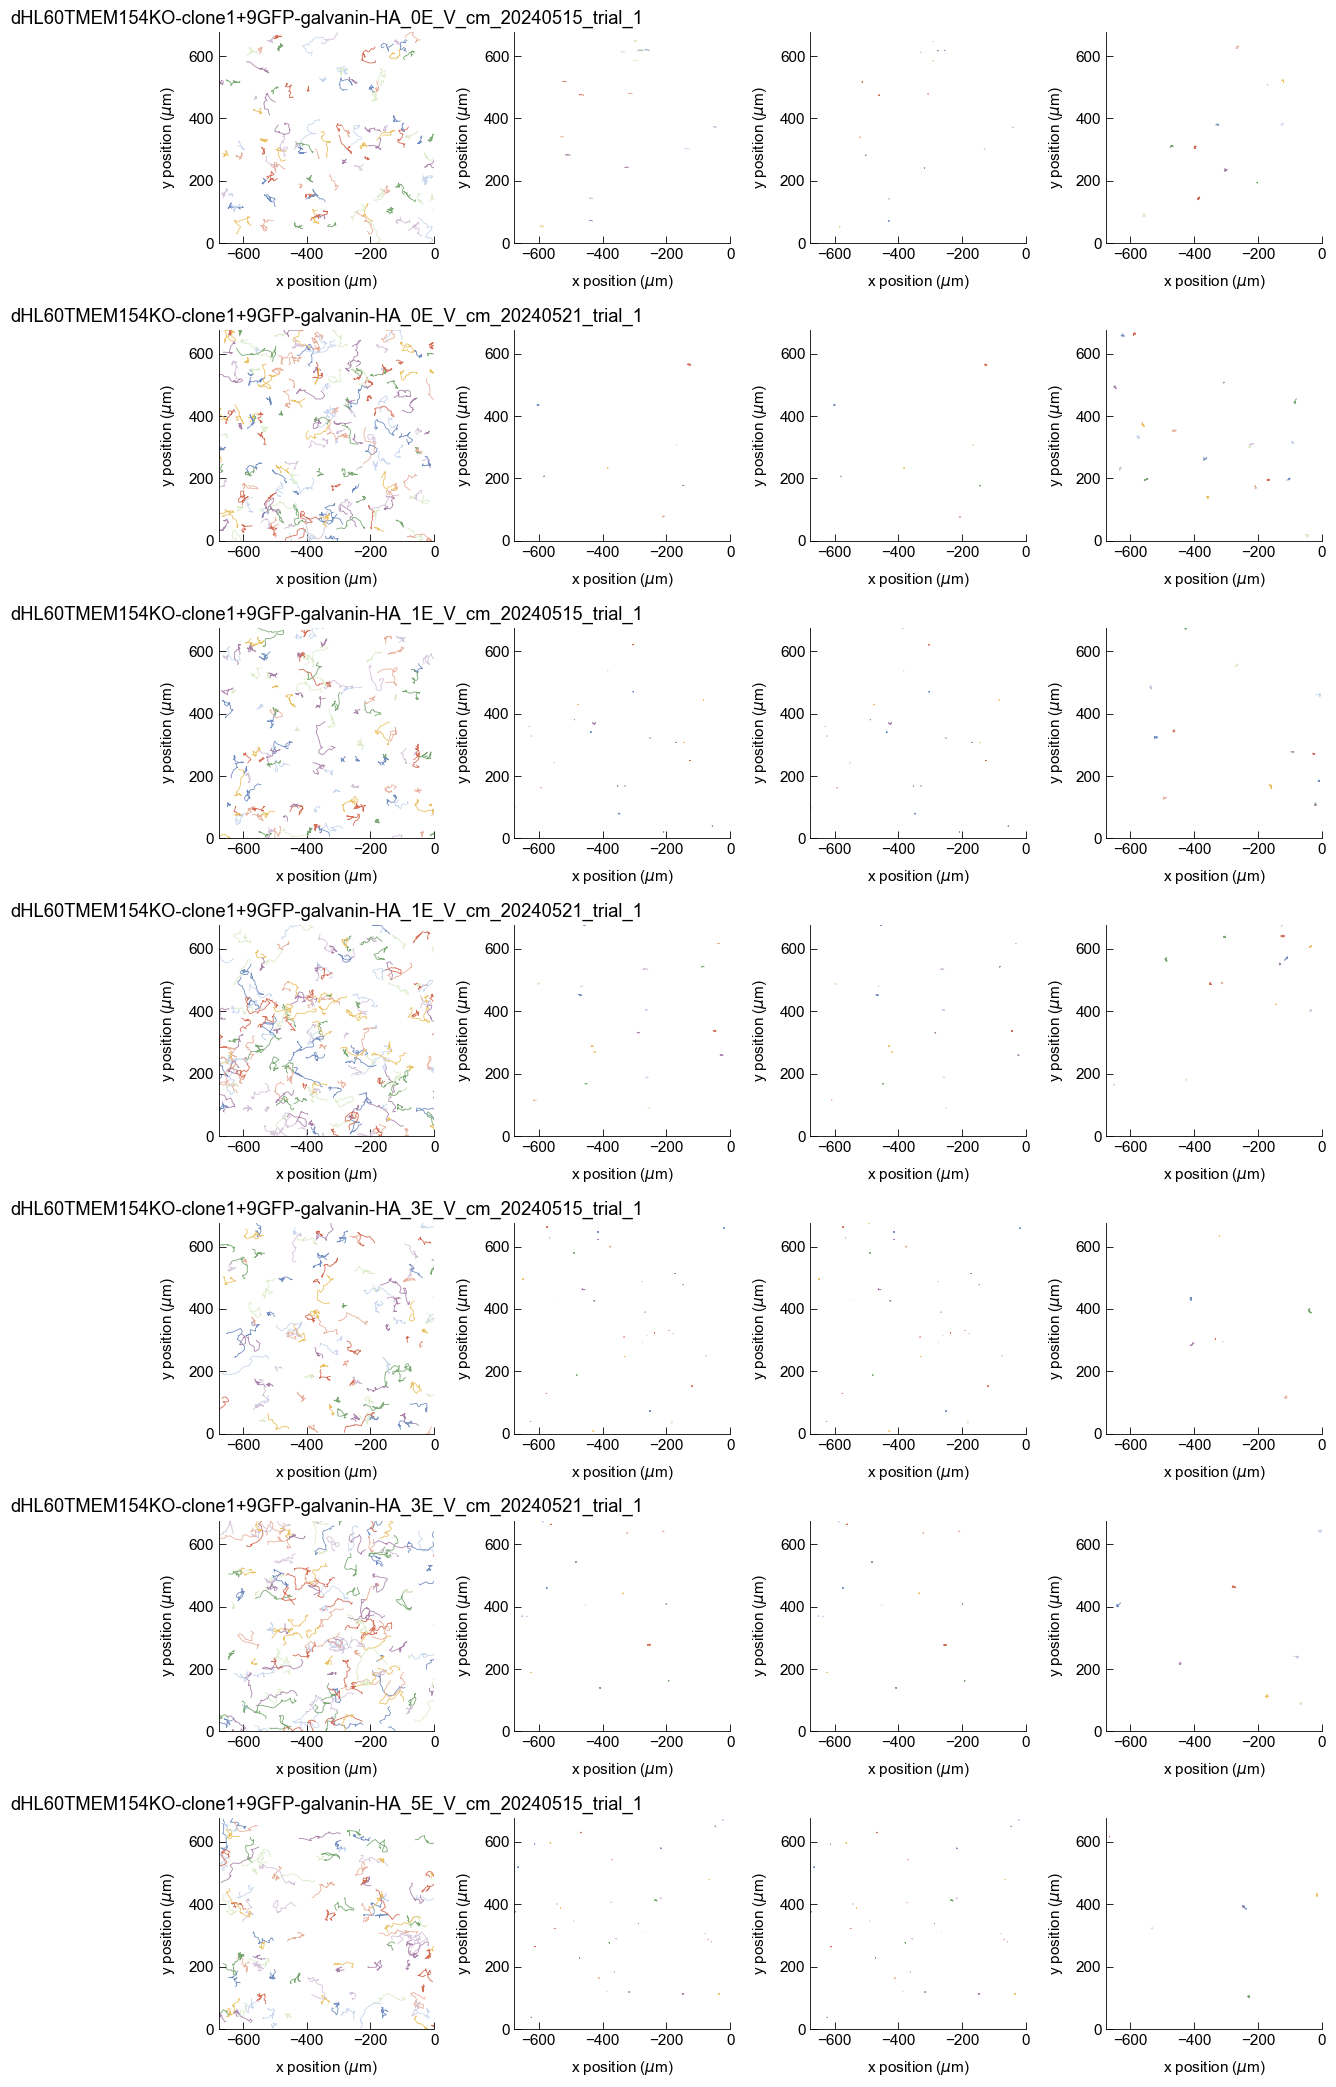

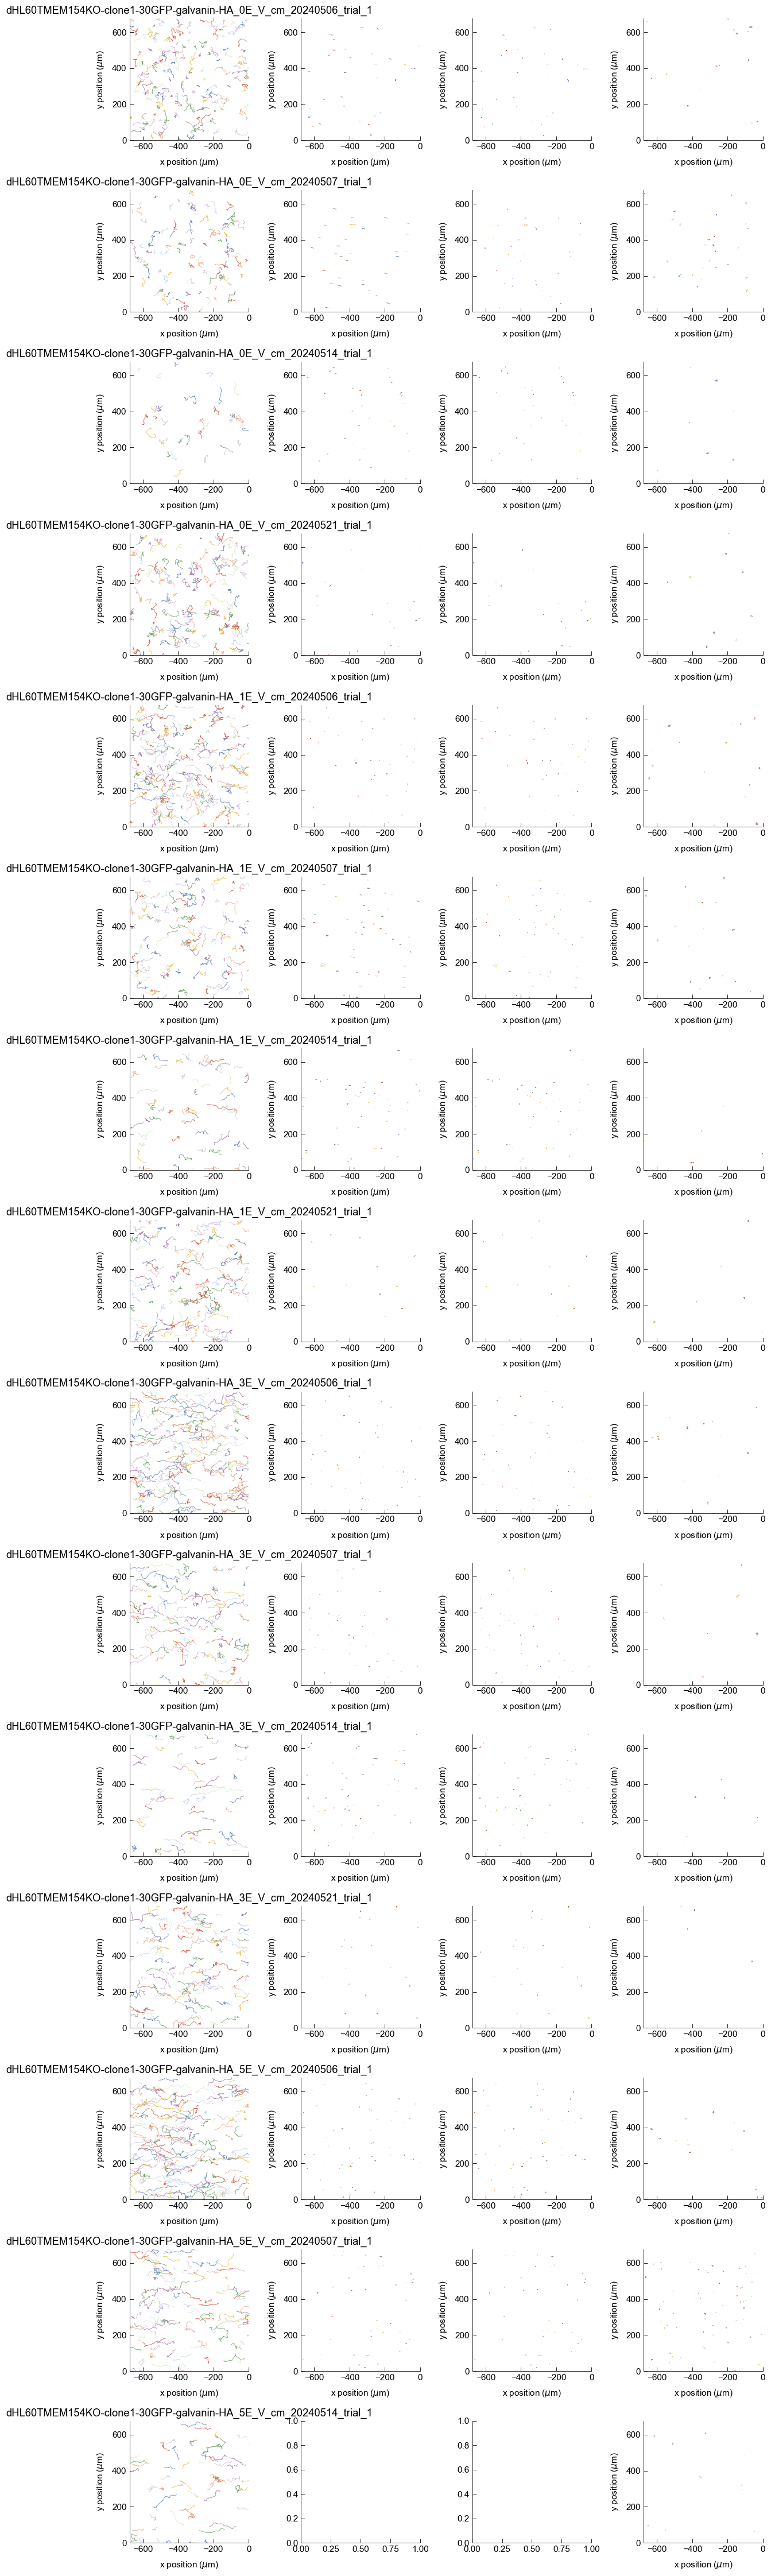

In [11]:
for sg, d in df_filtered.groupby(['celltype']):
    count = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
        count += 1

    f, ax = plt.subplots(count, 4, figsize=(12,count*3))    

    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
            
        ##################################
        # plot tracks
        ##################################
        for i in d_.cell.unique():
            data_ = d_[d_.cell==i]

            data_ = data_.replace([np.inf, -np.inf], np.nan)
            d_x = data_.x[~np.isnan(data_.x)] 
           
            if len(d_x)==0:
                continue

            ax[aq, 0].plot(data_.x_shifted.values - 1024.0*ip, 
                           1024.0*ip - data_.y_shifted.values)
            ax[aq, 0].set_xlabel('x position ($\mu$m)')
            ax[aq, 0].set_ylabel('y position ($\mu$m)')
            ax[aq, 0].set_xlim(-676,0)
            ax[aq, 0].set_ylim(0,676)
            ax[aq, 0].set_title(sg + '_' + str(g[0]) + 'E_V_cm_' + str(g[1]) +
                             '_trial_' + str(g[2]))
            
        aq += 1

    ##################################
    # non motile cells - uncorrected
    ##################################    
    d = df_ignore_nonmotile[df_ignore_nonmotile.celltype == sg]
    print(sg)
    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
            
        ##################################
        # plot tracks
        ##################################
        for i in d_.cell.unique():
            data_ = d_[d_.cell==i]

            data_ = data_.replace([np.inf, -np.inf], np.nan)
            d_x = data_.x[~np.isnan(data_.x)] 
           
            if len(d_x)==0:
                continue

            ax[aq, 1].plot(data_.x.values - 1024.0*ip, 
                           1024.0*ip - data_.y.values)
            ax[aq, 1].set_xlabel('x position ($\mu$m)')
            ax[aq, 1].set_ylabel('y position ($\mu$m)')
            ax[aq, 1].set_xlim(-676,0)
            ax[aq, 1].set_ylim(0,676)
            
        aq += 1
        
    ##################################
    # non motile cells - corrected
    ##################################        
    d = df_ignore_nonmotile[df_ignore_nonmotile.celltype == sg]
    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
            
        ##################################
        # plot tracks
        ##################################
        for i in d_.cell.unique():
            data_ = d_[d_.cell==i]

            data_ = data_.replace([np.inf, -np.inf], np.nan)
            d_x = data_.x[~np.isnan(data_.x)] 
           
            if len(d_x)==0:
                continue

            ax[aq, 2].plot(data_.x_shifted.values - 1024.0*ip, 
                           1024.0*ip - data_.y_shifted.values)
            ax[aq, 2].set_xlabel('x position ($\mu$m)')
            ax[aq, 2].set_ylabel('y position ($\mu$m)')
            ax[aq, 2].set_xlim(-676,0)
            ax[aq, 2].set_ylim(0,676)
            
        aq += 1
 
    d = df_ignore_other[df_ignore_other.celltype == sg]
    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
            
        ##################################
        # plot tracks
        ##################################
        for i in d_.cell.unique():
            data_ = d_[d_.cell==i]

            data_ = data_.replace([np.inf, -np.inf], np.nan)
            d_x = data_.x[~np.isnan(data_.x)] 

           
            if len(d_x)==0:
                continue

            ax[aq, 3].plot(data_.x_shifted.values - 1024.0*ip, 
                           1024.0*ip - data_.y_shifted.values)
            ax[aq, 3].set_xlabel('x position ($\mu$m)')
            ax[aq, 3].set_ylabel('y position ($\mu$m)')
            ax[aq, 3].set_xlim(-676,0)
            ax[aq, 3].set_ylim(0,676)
          
            
        aq += 1
            
        
        
    plt.tight_layout()

In [12]:
df_filtered['x'] = df_filtered['x_shifted'] 
df_filtered['y'] = df_filtered['y_shifted'] 
df_filtered['z'] = df_filtered['z_shifted'] 

In [13]:
df_filtered.head()

,cell,frame,x,y,z,celltype,E_V_cm,date,trial,user,x_shifted,y_shifted,z_shifted
0,3,0,252.243925,360.130815,220.702794,dHL60TMEM154KO-clone1+9GFP-galvanin-HA,0,20240515,1,HK,252.243925,360.130815,220.702794
1,3,1,255.418158,363.218407,218.694373,dHL60TMEM154KO-clone1+9GFP-galvanin-HA,0,20240515,1,HK,255.418158,363.218407,218.694373
2,3,2,256.874769,369.624201,216.593420,dHL60TMEM154KO-clone1+9GFP-galvanin-HA,0,20240515,1,HK,256.874769,369.624201,216.593420
3,3,3,257.306670,373.108395,219.479155,dHL60TMEM154KO-clone1+9GFP-galvanin-HA,0,20240515,1,HK,257.306670,373.108395,219.479155
4,3,4,257.538843,373.167138,222.743826,dHL60TMEM154KO-clone1+9GFP-galvanin-HA,0,20240515,1,HK,257.538843,373.167138,222.743826


## Plot trajectories

In [14]:
for g, d in df_filtered.groupby(['celltype', 'E_V_cm', 'trial', 'date', 'user']):

    num_cells = len(d.cell.unique())
    ###################################################
    ########### figure of absolute trajectories #######
    ###################################################
    
    f = plt.figure(figsize=(6,6))

    gs = gridspec.GridSpec(2, 2,height_ratios=[1,(1024.0*ip)/300], width_ratios=[(1024.0*ip)/300,1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])

    for c, d_  in d.groupby('cell'):

        if len(d_) <= 15:
            continue

        ax1.plot(d_.x - 1024.0*ip, 
                       d_.z)
        ax1.set_ylim(0,300)
        ax1.set_xlim(-676,0)
        ax2.plot(d_.x - 1024.0*ip, 
                       1024.0*ip - d_.y)
        ax2.set_xlabel('x position ($\mu$m)')
        ax2.set_ylabel('y position ($\mu$m)')
        ax2.set_xlim(-676,0)
        ax2.set_ylim(0,676)

        ax3.plot(d_.z, 
                 1024.0*ip - d_.y)

        ax1.xaxis.set_visible(False)
        ax1.set_ylabel('z ($\mu$m)')
        ax3.yaxis.set_visible(False)
        ax3.set_xlabel('z ($\mu$m)')
        ax3.set_xlim(0,300)
        ax3.set_ylim(0,676)

    plt.tight_layout()
    plt.savefig(f_dir + 'tracking_plots/' + 
            str(g[-1]) + '_' +
            g[0] + '_'  +
            str(g[1]) + 'Vcm_' + 
            str(g[2]) + '_user_' + str(g[-1]) + '_abs_trajectories.pdf')


    plt.close()

    ###################################################
    ########## figure of relative trajectories ########
    ###################################################
    f = plt.figure(figsize=(6,6))

    gs = gridspec.GridSpec(2, 2)

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])

    for c, d_  in d.groupby('cell'):

        if len(d_) <= 15:
            continue
            
        t0_x = d_[d_.frame == d_.frame.min()].x.values
        t0_y = d_[d_.frame == d_.frame.min()].y.values
        t0_z = d_[d_.frame == d_.frame.min()].z.values

        if np.shape(t0_x)== (0,):
            continue
        if len(d_.x.values) != len(d_.y.values):
            continue

        ax1.plot(d_.x - t0_x, 
                       d_.z - t0_z, color = 'k', alpha = 0.2, lw = 1)

        ax2.plot(d_.x - t0_x, 
                       d_.y - t0_y, color = 'k', alpha = 0.2, lw = 1)
        ax2.set_xlabel('x position ($\mu$m)')
        ax2.set_ylabel('y position ($\mu$m)')

        ax3.plot(d_.z - t0_z, 
                 d_.y - t0_y, color = 'k', alpha = 0.2, lw = 1)

        ax1.xaxis.set_visible(False)
        ax1.set_ylabel('z ($\mu$m)')
        ax3.yaxis.set_visible(False)
        ax3.set_xlabel('z ($\mu$m)')

    for ax_ in [ax1,ax2,ax3]:
        ax_.spines['left'].set_position(('data', 0))
        ax_.spines['bottom'].set_position(('data', 0))
        ax_.xaxis.set_label_coords(0.6, -0.05)
        ax_.yaxis.set_label_coords(0.0, 0.6)

        ax_.set_xlim(-150,150)
        ax_.set_ylim(-150,150)
        ax_.set_axisbelow(True)

    plt.tight_layout()
    plt.savefig(f_dir + 'tracking_plots/' + 
            str(g[-1]) + '_' +
            g[0] + '_'  +
            str(g[1]) + 'Vcm_' + 
            str(g[2]) + '_user_' + str(g[-1]) + '_rel_trajectories.pdf')

    
    plt.close()



In [15]:
for g, d in df_filtered.groupby(['celltype', 'E_V_cm']):

    ###################################################
    ########## figure of relative trajectories ########
    ###################################################
    f = plt.figure(figsize=(6,6))

    gs = gridspec.GridSpec(2, 2)

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])

    for i, d_ in d.groupby(['cell',  'trial', 'date', 'user']):

        if len(d_) <= 15:
            continue

        t0_x = d_[d_.frame == d_.frame.min()].x.values
        t0_y = d_[d_.frame == d_.frame.min()].y.values
        t0_z = d_[d_.frame == d_.frame.min()].z.values

        if np.shape(t0_x)== (0,):
            continue
        if len(d_.x.values) != len(d_.y.values):
            continue

        ax1.plot(d_.x - t0_x, 
                       d_.z - t0_z, color = 'k', alpha = 0.2, lw = 1, zorder = 20)

        ax2.plot(d_.x - t0_x, 
                       d_.y - t0_y, color = 'k', alpha = 0.2, lw = 1, zorder = 20)
        ax2.set_xlabel('x position ($\mu$m)')
        ax2.set_ylabel('y position ($\mu$m)')

        ax3.plot(d_.z - t0_z, 
                 d_.y - t0_y, color = 'k', alpha = 0.2, lw = 1, zorder = 20)

        ax1.xaxis.set_visible(False)
        ax1.set_ylabel('z ($\mu$m)')
        ax3.yaxis.set_visible(False)
        ax3.set_xlabel('z ($\mu$m)')

        
    for ax_ in [ax1,ax2,ax3]:
        ax_.spines['left'].set_position(('data', 0))
        ax_.spines['bottom'].set_position(('data', 0))
        ax_.xaxis.set_label_coords(0.6, -0.05)
        ax_.yaxis.set_label_coords(0.0, 0.6)

        ax_.set_xlim(-250,250)
        ax_.set_ylim(-250,250)
        ax_.set_axisbelow(True)


    plt.tight_layout()
    plt.savefig(f_dir + 'tracking_plots/' + 
            str(g[0]) + '_' + 
            str(g[1]) + 'Vcm_rel_trajectories.pdf')

    plt.close()





In [4]:
df_filtered = pd.read_csv('../../data/processed_tracking/20240607_compiled_galvaninKOlines_charged-eGFPtracking.csv')

In [5]:
df_filtered.head()

,Unnamed: 0,cell,frame,x,y,z,celltype,E_V_cm,date,trial,user,x_shifted,y_shifted,z_shifted
0,0,3,0,252.243925,360.130815,220.702794,dHL60TMEM154KO-clone1+9GFP-galvanin-HA,0,20240515,1,HK,252.243925,360.130815,220.702794
1,1,3,1,255.418158,363.218407,218.694373,dHL60TMEM154KO-clone1+9GFP-galvanin-HA,0,20240515,1,HK,255.418158,363.218407,218.694373
2,2,3,2,256.874769,369.624201,216.593420,dHL60TMEM154KO-clone1+9GFP-galvanin-HA,0,20240515,1,HK,256.874769,369.624201,216.593420
3,3,3,3,257.306670,373.108395,219.479155,dHL60TMEM154KO-clone1+9GFP-galvanin-HA,0,20240515,1,HK,257.306670,373.108395,219.479155
4,4,3,4,257.538843,373.167138,222.743826,dHL60TMEM154KO-clone1+9GFP-galvanin-HA,0,20240515,1,HK,257.538843,373.167138,222.743826
